In [15]:
%load_ext autoreload
%autoreload 2
from hypopredict.fusion.ml_preproc import MLPreprocessor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

mlp = MLPreprocessor()
path = '/Users/alexxela/code/hypopredict/data/processed/ml_prepped_cv_splits_20251216_125112.pkl'
loaded_dict = MLPreprocessor().load_prepped_splits(path)
splits_prepped = loaded_dict['splits_prepped']

# carefully drop na values from each split
for SPLIT_INDEX in range(len(splits_prepped)):
    splits_prepped[SPLIT_INDEX][0]['target'] = splits_prepped[SPLIT_INDEX][1].copy()
    splits_prepped[SPLIT_INDEX][0].dropna(inplace=True)
    splits_prepped[SPLIT_INDEX] = (splits_prepped[SPLIT_INDEX][0].drop('target', axis=1),
                                   splits_prepped[SPLIT_INDEX][0]['target'].to_numpy())

# instantiate CV
from hypopredict.cv import CrossValidator
cv = CrossValidator(splits=splits_prepped)
resample = True
desired_pos_ratio = .4
reduction_factor = .7

splits_prepped_resampled = splits_prepped.copy()
if resample:
    cv.desired_pos_ratio = desired_pos_ratio
    cv.reduction_factor = reduction_factor

    for SPLIT_INDEX in range(len(splits_prepped)):
        splits_prepped_resampled[SPLIT_INDEX] = (
            cv._resample_split_recursive(
                splits_prepped_resampled[SPLIT_INDEX],
                desired_pos_ratio=cv.desired_pos_ratio,
                reduction_factor=cv.reduction_factor,
            )
        )

# stack X_trains from ALL splits
X_train = pd.concat(
    [splits_prepped_resampled[i][0] for i in range(len(splits_prepped_resampled))]
)
y_train = np.hstack(
    [splits_prepped_resampled[i][1] for i in range(len(splits_prepped_resampled))]
)

# initialize XGBoost model
from xgboost import XGBClassifier
xgb = XGBClassifier(
    n_estimators=1212,
    max_depth=3,
    reg_lambda=0.1,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=17
)
xgb.fit(X_train, y_train)


from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=1.0, gamma="scale", probability=True))
])
svm.fit(X_train, y_train)


# fit a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


#### Load and drop NAs from Test data

In [ ]:
path = '/Users/alexxela/code/hypopredict/data/processed/TEST_ml_prepped_split_20251216_185549.pkl'
loaded_dict_test = MLPreprocessor().load_prepped_splits(path)
split_prepped_test = loaded_dict_test['splits_prepped']

In [17]:
# carefully drop na values from each split
SPLIT_INDEX = 0
split_prepped_test[SPLIT_INDEX][0]['target'] = split_prepped_test[SPLIT_INDEX][1].copy()
split_prepped_test[SPLIT_INDEX][0].dropna(inplace=True)
split_prepped_test[SPLIT_INDEX] = (split_prepped_test[SPLIT_INDEX][0].drop('target', axis=1),
                                split_prepped_test[SPLIT_INDEX][0]['target'].to_numpy())
# stack X_trains from other splits
X_test = split_prepped_test[0][0]
y_test = split_prepped_test[0][1]

y_probs_train_xgb = xgb.predict_proba(X_train)[:, 1]
y_probs_train_svm = svm.predict_proba(X_train)[:, 1]
y_probs_train_knn = knn.predict_proba(X_train)[:, 1]

y_probs_test_xgb = xgb.predict_proba(X_test)[:, 1]
y_probs_test_svm = svm.predict_proba(X_test)[:, 1]
y_probs_test_knn = knn.predict_proba(X_test)[:, 1]

X_train_fusion = pd.DataFrame({
    'xgb_prob': y_probs_train_xgb,
    'svm_prob': y_probs_train_svm,
    'knn_prob': y_probs_train_knn
})
X_train_fusion = pd.concat([X_train_fusion, X_train.reset_index(drop=True)], axis=1)


X_test_fusion = pd.DataFrame({
    'xgb_prob': y_probs_test_xgb,
    'svm_prob': y_probs_test_svm,
    'knn_prob': y_probs_test_knn
})
X_test_fusion = pd.concat([X_test_fusion, X_test.reset_index(drop=True)], axis=1)

X_train_fusion.head()

,xgb_prob,svm_prob,knn_prob,rolling_mean,rolling_std,rolling_min,rolling_max,rolling_median,rolling_skew,rolling_kurtosis
0,5.882882e-06,0.001020,0.0,1974.177403,53.725453,803.0,2717.0,1966.0,0.428226,11.049429
1,1.342140e-05,0.001029,0.0,1974.110247,52.947818,803.0,2717.0,1966.0,0.486645,11.421088
2,1.478668e-05,0.001053,0.0,1974.078155,51.668155,803.0,2717.0,1966.0,0.551383,12.177195
3,1.478668e-05,0.001053,0.0,1974.078155,51.668155,803.0,2717.0,1966.0,0.551383,12.177195
4,4.319437e-08,0.006167,0.0,1974.679912,48.376477,1574.0,2502.0,1966.0,0.882625,7.981472


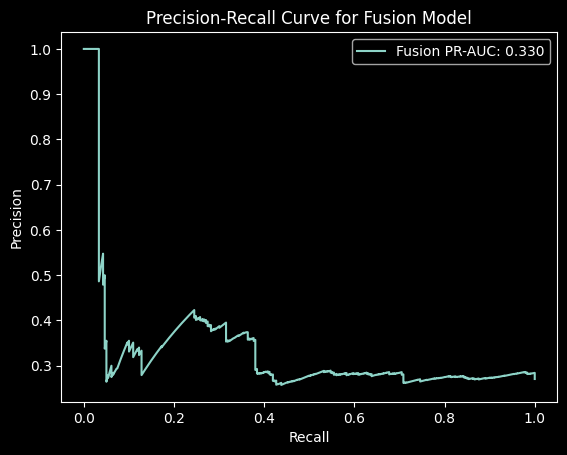

In [18]:
# fit a calibrated logistic regression model on fusion features
from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler
fusion = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=15000))
])

fusion.fit(X_train_fusion.iloc[:,:3], y_train)

# PR-AUC curve
from sklearn.metrics import precision_recall_curve, auc
y_probs_test_fusion = fusion.predict_proba(X_test_fusion.iloc[:,:3])[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_probs_test_fusion)
pr_auc_fusion = auc(recall, precision)


plt.plot(recall, precision, label=f'Fusion PR-AUC: {pr_auc_fusion:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Fusion Model')
plt.legend()
plt.show()

In [11]:
y_test.mean()

np.float64(0.13430591066325764)

In [12]:
scaler = StandardScaler()
X_train_fusion = scaler.fit_transform(X_train_fusion)
X_test_fusion = scaler.transform(X_test_fusion)

In [13]:
pd.DataFrame(X_train_fusion).describe().round(3)

,0,1,2,3,4,5,6,7,8,9
count,3784.000,3784.000,3784.000,3784.000,3784.000,3784.000,3784.000,3784.000,3784.000,3784.000
mean,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-0.901,-1.131,-1.008,-3.268,-1.140,-0.760,-3.421,-2.776,-6.560,-0.328
25%,-0.901,-1.097,-1.008,-0.771,-0.777,-0.725,0.029,-0.591,-0.402,-0.259
50%,-0.876,0.095,-0.385,0.089,-0.274,-0.431,0.416,-0.081,-0.122,-0.181
75%,1.135,1.036,1.170,0.315,0.322,0.120,0.674,0.284,0.333,-0.030
max,1.141,1.423,1.170,5.004,4.005,3.232,0.738,4.727,15.309,25.005


In [14]:
X_train_fusion.shape

(3784, 10)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

In [16]:
fusion_model = Sequential()
fusion_model.add(Input(shape=(X_train_fusion.shape[1],)))
fusion_model.add(Dense(4, activation='relu'))
fusion_model.add(BatchNormalization())
# fusion_model.add(Dropout(0.1))
fusion_model.add(Dense(8, activation='relu'))
fusion_model.add(BatchNormalization())
# fusion_model.add(Dropout(0.1))
fusion_model.add(Dense(1, activation='sigmoid'))

fusion_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=[AUC(name="auc", curve="PR")])

In [17]:
fusion_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 117 (468.00 B)

 Non-trainable params: 24 (96.00 B)

In [ ]:
es = EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

history_fusion = fusion_model.fit(X_train_fusion, y_train,
                 validation_data=(X_test_fusion, y_test),
                 callbacks=[es],
                 epochs=17, batch_size=32, verbose=1)

Epoch 1/17


In [30]:
fusion_model.evaluate(X_test_fusion, y_test)

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - auc: 0.1789 - loss: 0.6360 


[0.636030912399292, 0.1789007931947708]

In [32]:
fusion_model.predict(X_test_fusion)

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


array([[0.3472286 ],
       [0.34279463],
       [0.3423635 ],
       ...,
       [0.3912563 ],
       [0.39936072],
       [0.3993608 ]], shape=(6649, 1), dtype=float32)

---
---
---

#### CVing models

In [ ]:
# initialize XGBoost model
from xgboost import XGBClassifier
xgb = XGBClassifier(
    n_estimators=1212,
    max_depth=3,
    reg_lambda=0.05,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=17
)

In [ ]:
cv_results_xgb = cv.validate_model_cv(
                            xgb,
                            splits_prepped,
                            resample=True,
                            desired_pos_ratio=0.4,
                            reduction_factor=0.7
                )

In [ ]:
print("XGBoost mean CV PR AUCs:")
print(np.mean(cv_results_xgb['val_pr_aucs']))
print("XGBoost mean CV ave Prec:")
print(np.mean(cv_results_xgb['val_ave_precisions']))
print("Baseline:")
print(np.mean(cv._get_split_mean_labels(splits_prepped)))


XGBoost mean CV PR AUCs:
0.5804
XGBoost mean CV ave Prec:
0.5816
Baseline:
0.13596000000000003


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#svm = SVC(kernel ='poly', degree=3, C=100)
#svm.fit(X_train_features, y_train)

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=1.0, gamma="scale", probability=True))
])

In [ ]:
cv_results_svm = cv.validate_model_cv(
                            svm,
                            splits_prepped,
                            resample=True,
                            desired_pos_ratio=0.4,
                            reduction_factor=0.7
                )

In [ ]:
print("SVM mean CV PR AUCs:")
print(np.mean(cv_results_svm['val_pr_aucs']))
print("SVM mean CV ave Prec:")
print(np.mean(cv_results_svm['val_ave_precisions']))
print("Baseline:")
print(np.mean(cv._get_split_mean_labels(splits_prepped)))


SVM mean CV PR AUCs:
0.5444
SVM mean CV ave Prec:
0.5454
Baseline:
0.13596000000000003


In [ ]:
svm2 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="sigmoid", C=.1, gamma="scale", probability=True))
])

In [ ]:
cv_results_svm2 = cv.validate_model_cv(
                            svm2,
                            splits_prepped,
                            resample=True,
                            desired_pos_ratio=0.4,
                            reduction_factor=0.7
                )

In [ ]:
print("SVM2 mean CV PR AUCs:")
print(np.mean(cv_results_svm2['val_pr_aucs']))
print("SVM2 mean CV ave Prec:")
print(np.mean(cv_results_svm2['val_ave_precisions']))
print("Baseline:")
print(np.mean(cv._get_split_mean_labels(splits_prepped)))


SVM2 mean CV PR AUCs:
0.3881
SVM2 mean CV ave Prec:
0.3902
Baseline:
0.13596000000000003


In [ ]:
# fit a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
cv_results_knn = cv.validate_model_cv(
                            knn,
                            splits_prepped,
                            resample=True,
                            desired_pos_ratio=0.4,
                            reduction_factor=0.7
                )

In [ ]:
print("KNN mean CV PR AUCs:")
print(np.mean(cv_results_knn['val_pr_aucs']))
print("KNN mean CV ave Prec:")
print(np.mean(cv_results_knn['val_ave_precisions']))
print("Baseline:")
print(np.mean(cv._get_split_mean_labels(splits_prepped)))


KNN mean CV PR AUCs:
0.5816
KNN mean CV ave Prec:
0.5641
Baseline:
0.13596000000000003


---

#### Some usage

In [ ]:
mlp.set_params(chunk_size=pd.Timedelta(minutes=10),
                roll_window_size=pd.Timedelta(minutes=30))

In [ ]:
mlp.params

{'ecg_dir': '/Users/alexxela/code/hypopredict/data/feathers/',
 'glucose_src': 'local',
 'n_splits': 5,
 'chunk_size': Timedelta('0 days 00:10:00'),
 'step_size': Timedelta('0 days 00:10:00'),
 'forecast_window': Timedelta('0 days 01:30:00'),
 'roll_window_size': Timedelta('0 days 00:30:00'),
 'roll_step_size': Timedelta('0 days 00:02:00'),
 'suffix': 'rolling',
 'agg_funcs': ['mean', 'std', 'min', 'max', 'median', 'skew', 'kurtosis'],
 'random_state': 17}

In [ ]:
mlp.reset_params()

In [ ]:
mlp.params

{'ecg_dir': '/Users/alexxela/code/hypopredict/data/feathers/',
 'glucose_src': 'local',
 'n_splits': 5,
 'chunk_size': Timedelta('0 days 01:00:00'),
 'step_size': Timedelta('0 days 00:10:00'),
 'forecast_window': Timedelta('0 days 01:30:00'),
 'roll_window_size': Timedelta('0 days 00:40:00'),
 'roll_step_size': Timedelta('0 days 00:02:00'),
 'suffix': 'rolling',
 'agg_funcs': ['mean', 'std', 'min', 'max', 'median', 'skew', 'kurtosis'],
 'random_state': 17}

In [ ]:
from hypopredict.params import TRAIN_DAYS

In [ ]:
mlp.split(TRAIN_DAYS)

In [ ]:
mlp.splits

array([[71, 21, 14, 63],
       [24, 44, 61, 13],
       [52, 54, 43, 22],
       [92, 11, 51, 74],
       [42, 93, 82, 72]])

In [ ]:
# 20 mins to run
#mlp.preprocess()

Labeling day 71 with 91 chunks
Labeling day 21 with 47 chunks
Labeling day 14 with 44 chunks
Labeling day 63 with 84 chunks
Labeling day 24 with 74 chunks
Labeling day 44 with 68 chunks
Labeling day 61 with 117 chunks
Labeling day 13 with 77 chunks
Labeling day 52 with 82 chunks
Labeling day 54 with 45 chunks
Labeling day 43 with 49 chunks
Labeling day 22 with 80 chunks
Labeling day 92 with 87 chunks
Labeling day 11 with 74 chunks
Labeling day 51 with 71 chunks
Labeling day 74 with 83 chunks
Labeling day 42 with 74 chunks
Labeling day 93 with 71 chunks
Labeling day 82 with 104 chunks
Labeling day 72 with 66 chunks


In [ ]:
type(mlp.splits_prepped)

list

In [ ]:
len(mlp.splits_prepped)  # number of splits

5

In [ ]:
import pickle
import datetime
now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

filepath = f'/Users/alexxela/code/hypopredict/data/processed/'
filename = f'ml_prepped_cv_splits_{timestamp}.pkl'

dict_to_save = {"splits_prepped": mlp.splits_prepped, "params": mlp.params}

with open(filepath + filename, "wb") as f:
    pickle.dump(dict_to_save, f)

---
#### Preprocessing and saving test data

In [ ]:
from hypopredict.params import TEST_DAYS

In [ ]:
mlp.set_params(n_splits = 1)
mlp.split(TEST_DAYS)
mlp.preprocess()

Labeling day 53 with 85 chunks
Labeling day 41 with 73 chunks
Labeling day 31 with 98 chunks
Labeling day 62 with 67 chunks
Labeling day 12 with 65 chunks
Labeling day 73 with 120 chunks
Labeling day 23 with 81 chunks
Labeling day 81 with 93 chunks


In [ ]:
import pickle
import datetime
now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

filepath = f'/Users/alexxela/code/hypopredict/data/processed/'
filename = f'TEST_ml_prepped_split_{timestamp}.pkl'

dict_to_save = {"splits_prepped": mlp.splits_prepped, "params": mlp.params}

with open(filepath + filename, "wb") as f:
    pickle.dump(dict_to_save, f)

---
#### Preprocessing and saving DEMO data

In [1]:
from hypopredict.params import DEMO_DAYS

In [3]:
from hypopredict.fusion.ml_preproc import MLPreprocessor
mlp = MLPreprocessor()
mlp.set_params(n_splits = 1)
mlp.split(DEMO_DAYS)
mlp.preprocess()

Labeling day 64 with 69 chunks
Labeling day 83 with 128 chunks


In [4]:
import pickle
import datetime
now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

filepath = f'/Users/alexxela/code/hypopredict/data/processed/'
filename = f'DEMO_ml_prepped_split_{timestamp}.pkl'

dict_to_save = {"splits_prepped": mlp.splits_prepped, "params": mlp.params}

with open(filepath + filename, "wb") as f:
    pickle.dump(dict_to_save, f)